In [1]:
# IMPORTS
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score,accuracy_score
from sklearn.impute import KNNImputer


# Step 1: Data Loading and EDA

In [2]:
df = pd.read_excel("data/titanic3.xls") # This DF is reserved for model training 
dfEDA = df.copy() # This is a copy of the dataframe I will use to do eda I realsied that I should have include this in the beggining 
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [3]:
# First I want to look at the number of rows and columns
print(f"Dataset Shape:{dfEDA.shape}") 

Dataset Shape:(1309, 14)


We see there are 1309 passangers (rows) and 14 features (columns)

In [4]:
# Show column data types and names
print("\nColumn Data Types:")
print(dfEDA.dtypes) 


Column Data Types:
pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object


Personal Thoughts/Interpretation:
- Mix of numerical and categorical variables
- Target variable in this case is 1 = Survived 0 = Died
- Here im starting to think through what could contribute and couldnt contribute to survival(predictive/non predictive features) and what features directly reveal survival (data leakage)

In [5]:
# Now for how many missing values we have to account for
print("\nMissing Values per Column:")
print(dfEDA.isnull().sum()) 


Missing Values per Column:
pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64


Personal Thoughts/Interpretation:
- Cabin -> a large number of passangers didnt have a recorded cabin. 
    - Impact? -> might be very difficult to meaningfully impute missing values.
- Boat -> Many passengers didn’t have a recorded lifeboat.
    - Impact? -> Directly indicates survival, creating data leakage so I should drop the column
- Body -> A large number of passengers don’t have a recorded body recovery.
    - Impact? -> If a body was recovered, it confirms non-survival, making this another data leakage risk. I.e. drop the column.
- Home.dest -> Many passengers don’t have a recorded home destination.
    - Impact? -> Could be linked to socio-economic status, which may affect survival rates. Needs further analysis to determine its importance. Could investigate correlation with pclass and fare, then decide whether to drop or transform.
- Age -> A significant portion of passengers don’t have an age recorded.
    - Impact? -> Age is an important predictor of survival  (children prioritized in lifeboats). 
- Embarked -> A very small number of passengers don’t have a recorded embarkation point.
    - Impact? -> Missing values are minimal and can be easily filled with the most common value ("mode"). 
- Fare -> Only one missing value in the dataset.
    - Impact? -> Missing data is insignificant, so a simple imputation works. 


In [6]:
dfEDA.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


Personal Thoughts/Interpretation:
1. Survived: 38% of passengers survived, meaning the dataset is imbalanced (need to apply balancing technique). Standard deviation = 0.49, meaning almost equal distribution, but slightly more non-survivors.
2. Pclass: Median is 3 meaning at least 50% of passangers where in 3rd class
3. Age: Mean = 29.88 passengers were mostly young adults. Min = 0.16 (infant), Max = 80 (elderly) implying we have a large age range.
4. sibsp: Mean = 0.5 meaning most pasangers where travelling alone or with one sibling/spouse
5. parch: Mean = 0.38 -> Most passengers were not traveling with parents/children.
6. fare: Mean = 33.29, Median = 14.45 indicating a highly right skewed distribution.
7. body: Data leakage by telling us who died

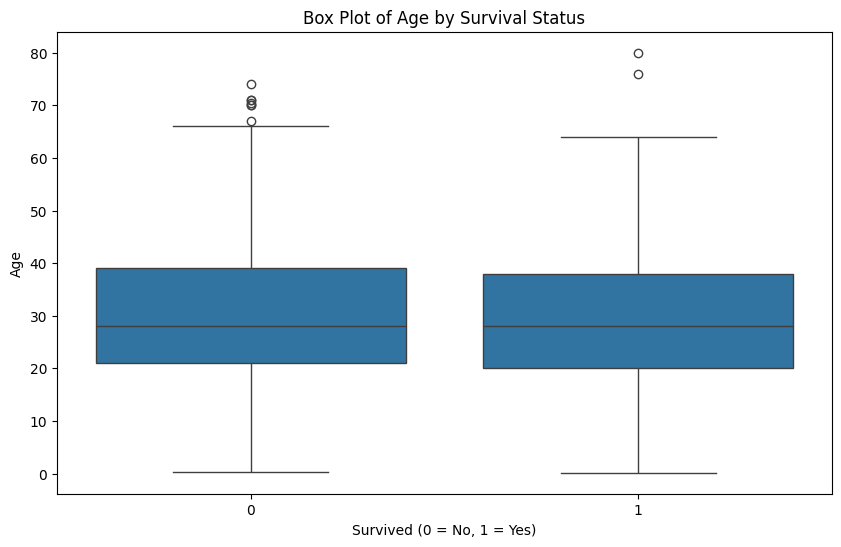

In [7]:
## Box Plot for age 
plt.figure(figsize=(10, 6))
sns.boxplot(x='survived', y='age', data=df)
plt.title("Box Plot of Age by Survival Status")
plt.xlabel("Survived (0 = No, 1 = Yes)")
plt.ylabel("Age")
plt.show()

Personal Thoughts/Interpretation:

- Median age is almost identical across survivors and non-survivors, suggesting age alone is not a strong predictor of survival
- Age distribution appears again identical for both groups pointing towards no clear cutoff where survival drastically changes based on age
- Upper whisker for non survivors extends a tiny bit higher but is not that signiificant to base the whole model on this feature alone.

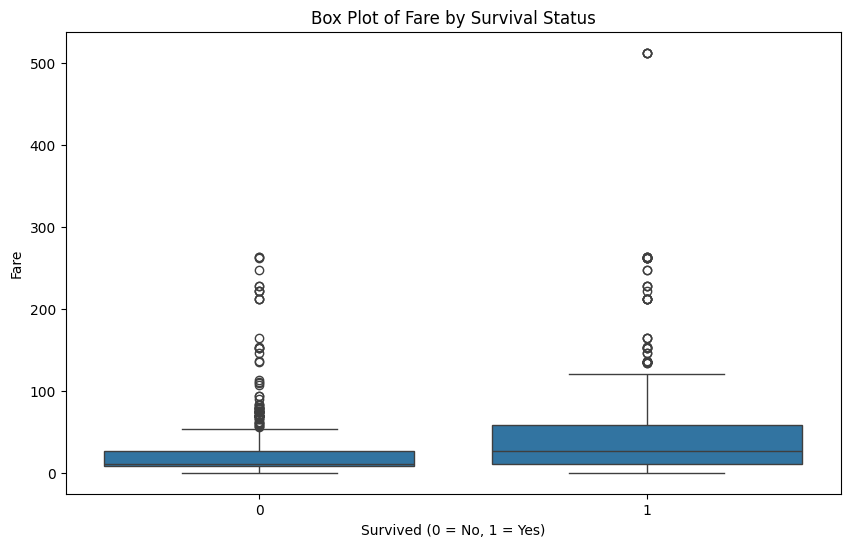

In [8]:
# Box plot for fare or class 
plt.figure(figsize=(10, 6))
sns.boxplot(x='survived', y='fare', data=df)
plt.title("Box Plot of Fare by Survival Status")
plt.xlabel("Survived (0 = No, 1 = Yes)")
plt.ylabel("Fare")
plt.show()

Personal Thoughts/Interpretation:
- Median fare is higher for those who survived indincating that economic status plays a role
- Survivors had a much wider fare range with one high value outlier
- Insights:
    - Confirms hypothesis that higher ticket prices correlated with higher priority in evacuating the ship and thus better survivial chances
    - We need to handle outliers. Some very high fares might distort the anlayis a log transformation or removing these outliers could help normalise the distribution

- Questions?
    - if we go with the notion that women and children where evacuated first: Did wealthy women and childrenhave a disproportionatly higher survival rate?
    - did thrid class passangers who paid higher fares than the rest have better survival chances than those in 3rd class who didnt?

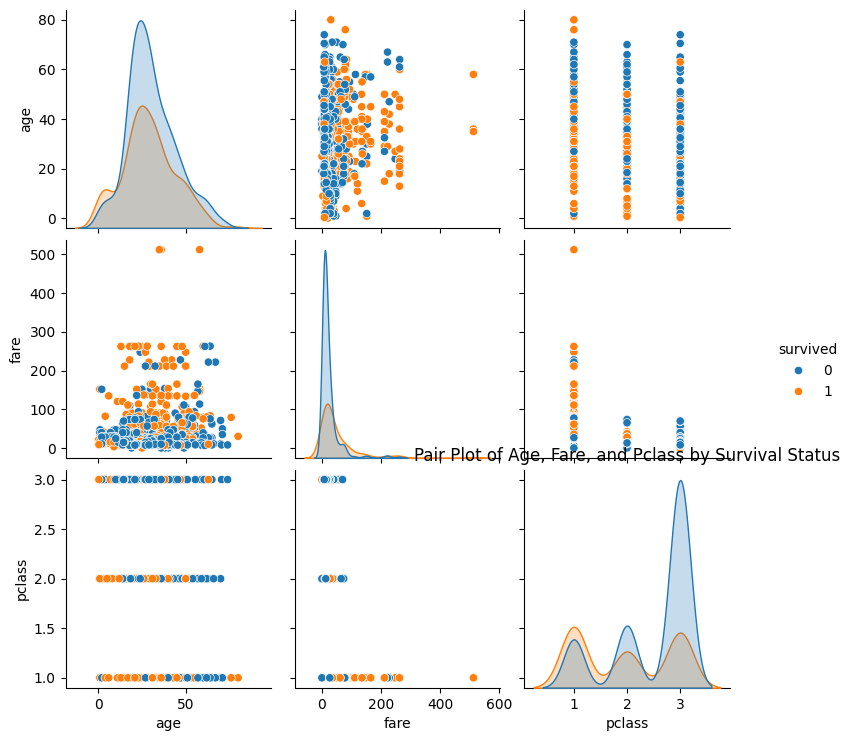

In [9]:
#First a pair plot to see the features relationship with the target variable. Specifically AGE, FARE, Pclass ›
sns.pairplot(df, hue='survived', vars=['age', 'fare', 'pclass'])
plt.title("Pair Plot of Age, Fare, and Pclass by Survival Status")
plt.show()

Personal Thoughts/Interpretation:
- Fare has outliers we need to deal with as some passangers paid extremely high fares
- The three distinct levels (1, 2, 3) confirm that pclass is categorical. Still need to decided if we leave the blank pclass values as a fourth category "unkown"
- The age distribution suggests grouping into categories through binning them. This could improve interperetability. 
- Fare and Class are correlated so we should remove one of them to address multicollinearity issues

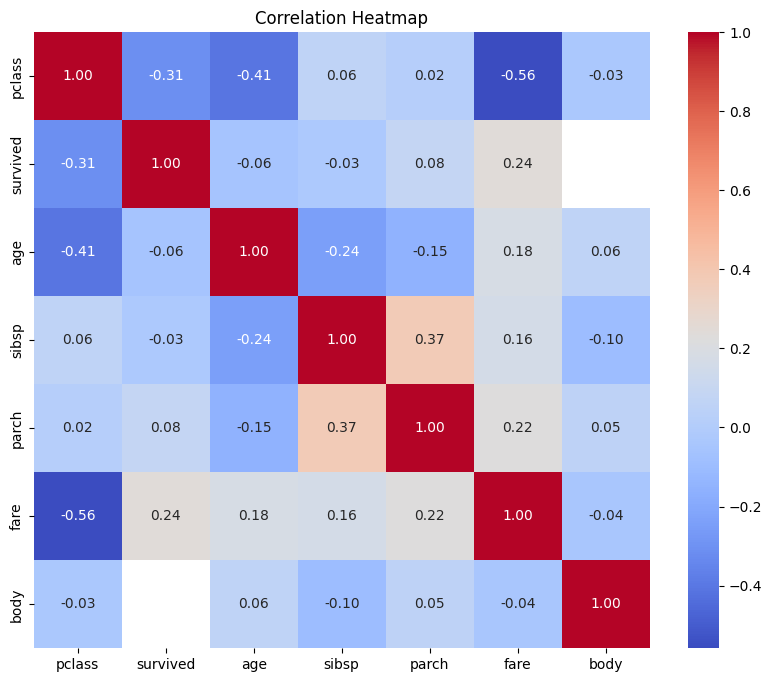

In [10]:
# CORRELATION HEAT MAP USING ONLY NUMERIC VALUES

numericDF = dfEDA.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numericDF.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Heatmap")
plt.show()

Personal Thoughts/Interpretation:

- One further analysis this correlation map does not provide valuable inforamtion. Leading me to want to explore categorical variables in more depth with count plots and pie charts 

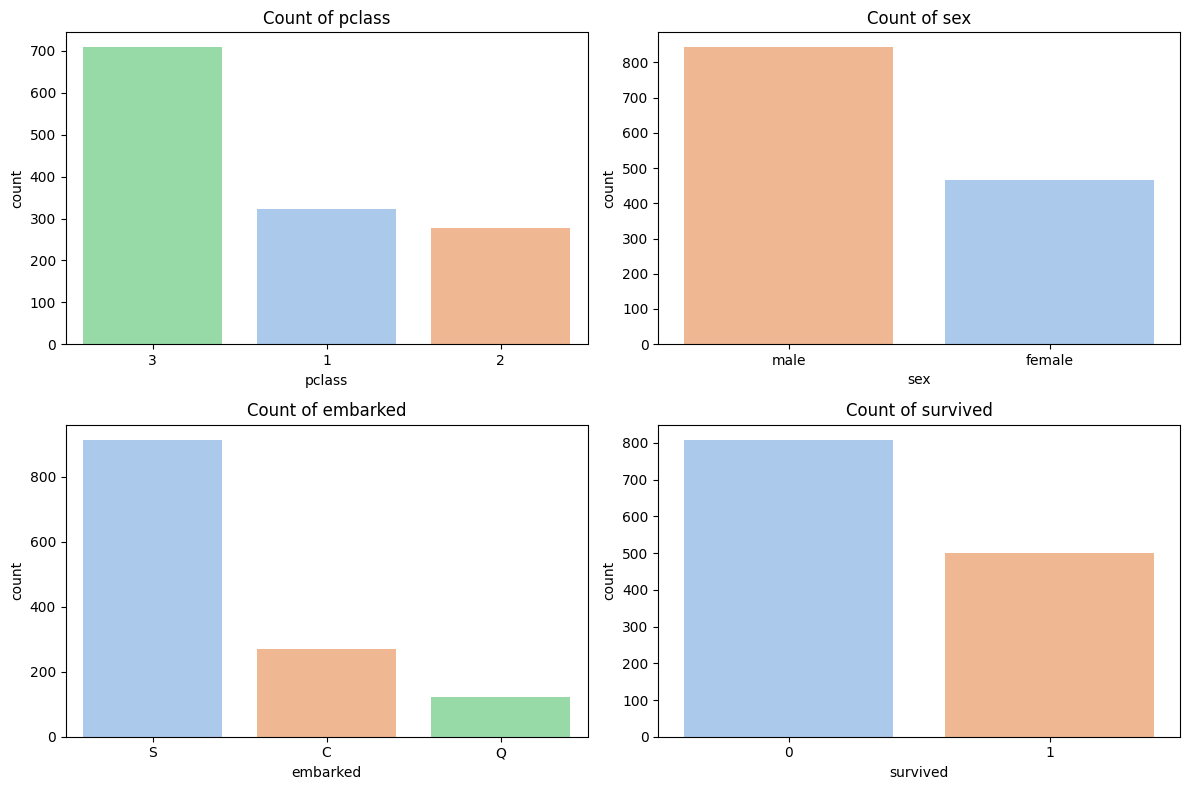

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
categoricalCols = ['pclass', 'sex', 'embarked', 'survived']

for col, ax in zip(categoricalCols, axes.flatten()):
    if col in dfEDA.columns:
        sns.countplot(x=df[col], hue=df[col], ax=ax, order=df[col].value_counts().index, palette="pastel", legend=False)
        ax.set_title(f"Count of {col}")
    else:
        ax.set_title(f"{col} not found in dataset")

plt.tight_layout()
plt.show()


Passanger Class Distribution:
- As expected majority of passangers where in 3rd class
- Followed by fewer in 1st and second class
Gender Distribution:
- More Males exist in the dataset
Embarkation Port:
- Most passangers boarded on S then C then Q 


Next steps: 
- Compare survival rates by class to see if wealthier passengers had an advantage
- Compare male vs female survival rates to confirm gender-based advantages.
- Check if female survival was higher in 1st class compared to 3rd class.
- Does embarkation port correlate with class and thus is linked to survival?

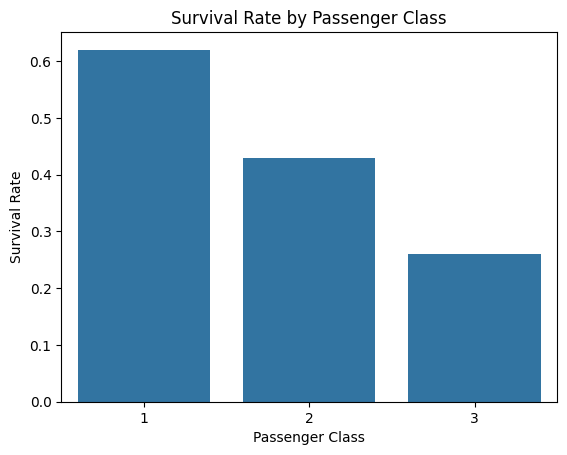

Survival Rate by Gender:
 sex
female    0.73
male      0.19
Name: survived, dtype: float64


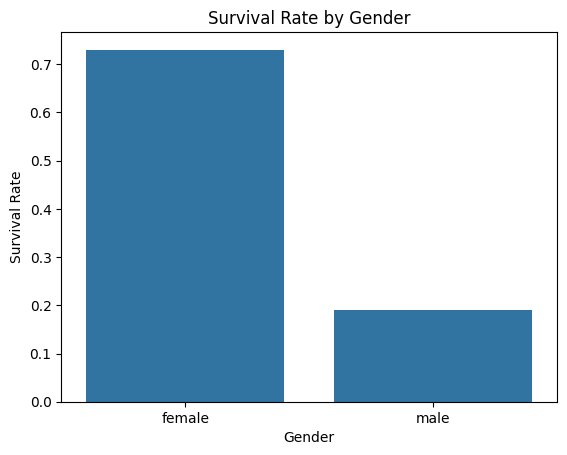

Survival Rate by Class and Gender:
 sex     female  male
pclass              
1         0.97  0.34
2         0.89  0.15
3         0.49  0.15


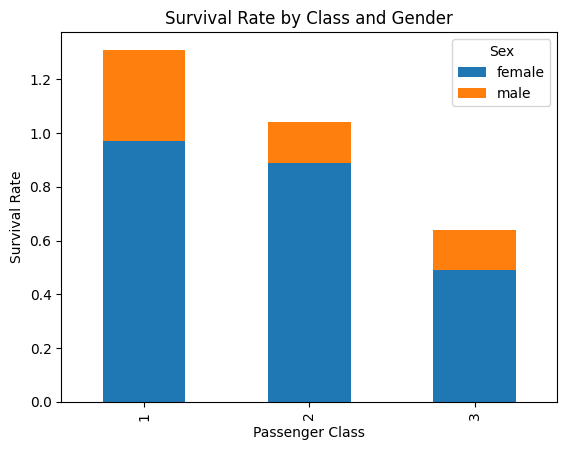

Class Distribution by Embarkation Port:
 pclass           1         2         3
embarked                              
C         0.522222  0.103704  0.374074
Q         0.024390  0.056911  0.918699
S         0.193654  0.264770  0.541575
Survival Rate by Embarkation Port:
 embarked
C    0.56
Q    0.36
S    0.33
Name: survived, dtype: float64


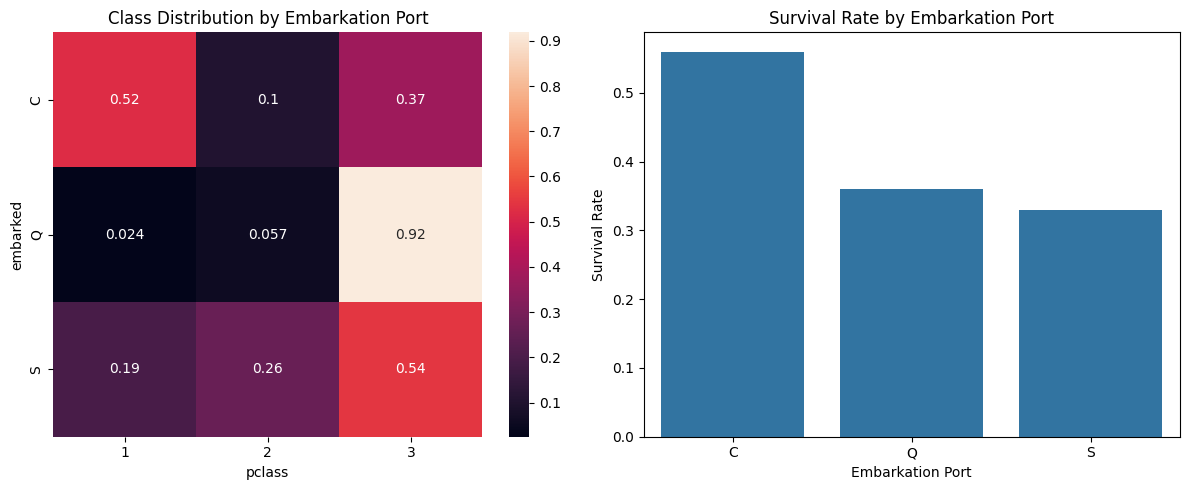

In [12]:
# checking survival rate
survival_by_class = dfEDA.groupby("pclass")["survived"].mean().round(2)
sns.barplot(x=survival_by_class.index, y=survival_by_class.values)
plt.xlabel("Passenger Class")
plt.ylabel("Survival Rate")
plt.title("Survival Rate by Passenger Class")
plt.show()
# Survival rate by gender
survival_by_gender = dfEDA.groupby("sex")["survived"].mean().round(2)
print("Survival Rate by Gender:\n", survival_by_gender)
sns.barplot(x=survival_by_gender.index, y=survival_by_gender.values)  
plt.xlabel("Gender")
plt.ylabel("Survival Rate")
plt.title("Survival Rate by Gender")
plt.show()

# Survival rate by calss and gender
survival_by_class_gender = dfEDA.groupby(["pclass", "sex"])["survived"].mean().round(2).unstack()
print("Survival Rate by Class and Gender:\n", survival_by_class_gender)
survival_by_class_gender.plot(kind="bar", stacked=True)
plt.xlabel("Passenger Class")
plt.ylabel("Survival Rate")
plt.title("Survival Rate by Class and Gender")
plt.legend(title="Sex")
plt.show()

# Check survival rate by embarkation port
class_by_embarkation = dfEDA.groupby("embarked")["pclass"].value_counts(normalize=True).unstack()
print("Class Distribution by Embarkation Port:\n", class_by_embarkation)
survival_by_embarkation = dfEDA.groupby("embarked")["survived"].mean().round(2)
print("Survival Rate by Embarkation Port:\n", survival_by_embarkation)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(class_by_embarkation, annot=True, ax=axes[0])
axes[0].set_title("Class Distribution by Embarkation Port")
sns.barplot(x=survival_by_embarkation.index, y=survival_by_embarkation.values, ax=axes[1])
axes[1].set_xlabel("Embarkation Port")
axes[1].set_ylabel("Survival Rate")
axes[1].set_title("Survival Rate by Embarkation Port")
plt.tight_layout()
plt.show()

Quick and consice analysis of the charts:
- First-class passengers had the highest survival rate, while third-class had the lowest.
- Females had a much higher survival rate (~75%) compared to males (~21%), confirming gender-based survival advantage.
- First-class women had the highest survival rate, while third-class men had the lowest chance of survival.
- Cherbourg had the highest proportion of first-class passengers, while Queenstown had mostly third-class passengers.
- Passengers who embarked at Cherbourg had the highest survival rate, likely due to a higher number of first-class passengers.



What I will keep in mind to engieer meaningful features from the EDA:
- Encoding pclass will be very important since it is such a strong indicator
- Sex is also a very strong indicator and we can binary encode it 
- Embarkation port will also need to be encoded properly since its such a strong indicator
- I could create an interaction faeture between pclass and sex since women in 1st class and men in 3rd class where strong predictors of survival or no survival

These are only preliminary thoughts written down and will be justified further along in the notebook but serve as a reminder for me....

# Step 2: Managing Missing Values (Pre-split)

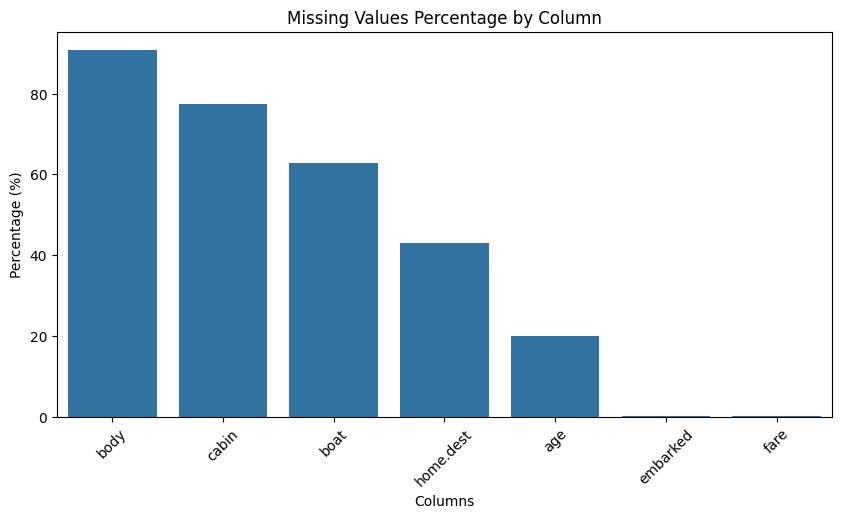

In [13]:
# Here Im checking for missing values
values_missing = dfEDA.isnull().sum()
percentage_missing = (values_missing / len(dfEDA)) * 100

# now I want to display this percentage wise and sorted

data_missing = pd.DataFrame({'Missing Values': values_missing, 'Percentage': percentage_missing })
data_missing = data_missing[data_missing['Missing Values']> 0].sort_values(by='Percentage', ascending = False)

plt.figure(figsize =(10,5))
sns.barplot(x=data_missing.index, y = data_missing['Percentage'])
plt.xticks(rotation=45)
plt.title("Missing Values Percentage by Column")
plt.xlabel("Columns")
plt.ylabel("Percentage (%)")
plt.show()


In [14]:
# Dropping Columns I justified earlier

df.drop(columns = ['name', 'body', 'boat', 'cabin', 'ticket'], inplace = True)

# Check the new data frame
df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked,home.dest
0,1,1,female,29.0000,0,0,211.3375,S,"St Louis, MO"
1,1,1,male,0.9167,1,2,151.5500,S,"Montreal, PQ / Chesterville, ON"
2,1,0,female,2.0000,1,2,151.5500,S,"Montreal, PQ / Chesterville, ON"
3,1,0,male,30.0000,1,2,151.5500,S,"Montreal, PQ / Chesterville, ON"
4,1,0,female,25.0000,1,2,151.5500,S,"Montreal, PQ / Chesterville, ON"


Recap of why i dropped these columns:
Data leakage: boat and boady
Non Predictive: name and ticket
Excessive missing values (+70%): cabin

Now lets look at home destination. Since over 40% of values are missing it could be better to remove it however it could correlate with socio economic status. I will check this by correlating home destiantion with survival.

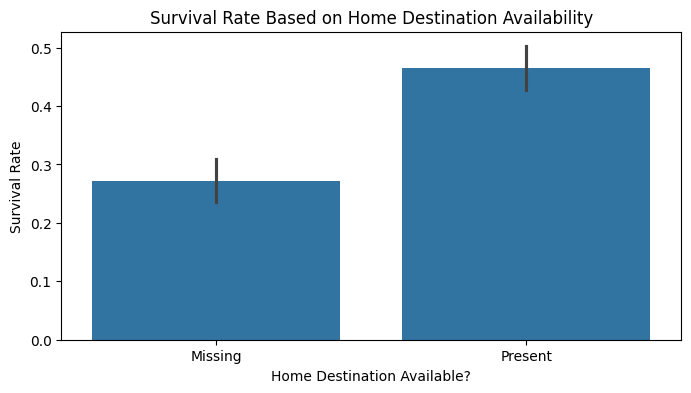

In [15]:
# Home destination correlation with survival
plt.figure(figsize=(8,4))
sns.barplot(x=dfEDA['home.dest'].notnull(), y=dfEDA['survived'])
plt.xticks([0,1], ['Missing', 'Present'])
plt.title("Survival Rate Based on Home Destination Availability")
plt.xlabel("Home Destination Available?")
plt.ylabel("Survival Rate")
plt.show()


Passengers with a recorded home.dest had a survival rate of ~45%, while those without it had a survival rate of ~30%.

Could be down to wealthier passangers having pre-arragned accomodations while migrnats may not have had permanent residence yet. That being said Since fare and pclass already indicate socio-economic status, keeping home.dest might not add much value. and we could drop it from the data set to simplify things.

In [16]:
if 'home.dest' in df.columns:
    df.drop(columns=['home.dest'], inplace=True)
df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1,1,female,29.0000,0,0,211.3375,S
1,1,1,male,0.9167,1,2,151.5500,S
2,1,0,female,2.0000,1,2,151.5500,S
3,1,0,male,30.0000,1,2,151.5500,S
4,1,0,female,25.0000,1,2,151.5500,S


In [17]:
# Filling missing categorical variables with place holder
df["embarked"] = df["embarked"].fillna("Unknown")
print("Number of missing values in embarked:", df["embarked"].isnull().sum())
df.head()

Number of missing values in embarked: 0


,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1,1,female,29.0000,0,0,211.3375,S
1,1,1,male,0.9167,1,2,151.5500,S
2,1,0,female,2.0000,1,2,151.5500,S
3,1,0,male,30.0000,1,2,151.5500,S
4,1,0,female,25.0000,1,2,151.5500,S


# Step 3: Data Splitting

As I explained in the README, ive handled missing values before splitting meaning my next task is to split the dataset correctly to avoid data leakage.

The Titanic dataset has ~1300 samples, which is relatively small. In order maximize learning while ensuring reliable evaluation I will use a 3-way split strategy: 70% train, 15% validation, 15% test.

Since survival is imbalanced (more died than survived) it is important I pay close attention ensure class distribution is consistent across all 3 splits. A random split may result in uneven survival distributions but a stratified sampling approach will maintain the original survival ratio.

In [18]:
# Define features (X) and target (y)
# X contains independent variables excluding survived since thats the target
X = df.drop(columns=["survived"])
# Y just contains the dependent variable  
y = df["survived"]  

# This splits the data into train (70%) and temp (30%) using stratification
# stratify = y ensures the proportion of survivors and non survivors remains the same in both splits
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# this takes the tempoary sets and further splits them 50-50 into validation and test sets
# again here we ensure that the survial distribution is consisent in both validation and test sets using stratify = y_temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# just double checking by prining the number of rows and columns in each dataset to confirm the split occured properly
print(f"Training Set: {X_train.shape}, Validation Set: {X_val.shape}, Test Set: {X_test.shape}")


Training Set: (916, 7), Validation Set: (196, 7), Test Set: (197, 7)


# Step 2 Revisited... (Post split!!!!)

In [19]:
# Check for missing values in the train split
missing_values = X_train.isnull().sum()
# filter only columns with missing values
missing_values = missing_values[missing_values > 0] 
# Display missing values
print("Missing Values After Dropping Columns:\n", missing_values)

Missing Values After Dropping Columns:
 age     190
fare      1
dtype: int64


AGE:
- in my previous attempt I tried to linearly impute age to no effect then I moved on to using a grouped median with better results. 
- I would like to try KNN (https://medium.com/@piyushkashyap045/handling-missing-values-in-data-a-beginner-guide-to-knn-imputation-30d37cc7a5b7#:~:text=K%2DNearest%20Neighbors%20(KNN)%20imputation%20is%20one%20of%20the,to%20calculate%20the%20missing%20values.) 
Fare: 
- Since we are just missing one value we could go with median imputation 
REMINDER: -> embarked was set to unkown but only contained around 2-3 missing values so I will probably just impute this using mode. Instead of OHE as a seperate column due to only 2-3 embarked rows missing

In [20]:
# If I want to do KNN imputation for age! Lets chekc if 190 missing age values is enough:
missing_percentage = (190 / X_train.shape[0]) * 100
print(f"Percentage of missing age values in training data: {missing_percentage:.2f}%")
# I think we dont have enough chatgpt said <10% is a good threshold to puruse KNN ;)

Percentage of missing age values in training data: 20.74%


Initially, I used global median imputation to fill missing age values. However after visualizing the distribution I noticed a sharp spike at the median age (~30 years old), which suggested that many passengers were assigned the same imputed value. This could introduce bias and affect model learning as it doesn't preserve the natural variation in age. Further down you will see I plotted the disributions. To correct this I restarted the kernel to reset the dataset and switched to Grouped Median Imputation, which considers the relationship between age, pclass, and sex.

Why did I choose grouped median on pclass and sex?
pclass: Wealthier individuals i.e 1st class were typically older, while 3rd class passengers were often younger migrants or workers.
Sex: Women in higher classes tended to be older traveling with families. whereas younger men were more common in 3rd class.

In [21]:
# Compute medians and mode from training set ONLY
# Grouped median for age
age_medians = X_train.groupby(["pclass", "sex"])["age"].median()  
# Standard median for fare
fare_median = X_train["fare"].median()  
# Mode for embarked
embarked_mode = X_train["embarked"].mode()[0]  

# Function to apply grouped median imputation
def fill_age_with_grouped_median(df):
    return df.apply(lambda row: age_medians[row["pclass"], row["sex"]] if pd.isnull(row["age"]) else row["age"], axis=1)

# Apply imputations to each dataset
X_train = X_train.assign(
    age=fill_age_with_grouped_median(X_train),
    fare=X_train["fare"].fillna(fare_median),
    embarked=X_train["embarked"].fillna(embarked_mode)
)
X_val = X_val.assign(
    age=fill_age_with_grouped_median(X_val),
    fare=X_val["fare"].fillna(fare_median),
    embarked=X_val["embarked"].fillna(embarked_mode)
)

X_test = X_test.assign(
    age=fill_age_with_grouped_median(X_test),
    fare=X_test["fare"].fillna(fare_median),
    embarked=X_test["embarked"].fillna(embarked_mode)
)
# Check for any remaining missing values
print("Missing values after imputation (Train):\n", X_train.isnull().sum())
print("Missing values after imputation (Validation):\n", X_val.isnull().sum())
print("Missing values after imputation (Test):\n", X_test.isnull().sum())


Missing values after imputation (Train):
 pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
dtype: int64
Missing values after imputation (Validation):
 pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
dtype: int64
Missing values after imputation (Test):
 pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
dtype: int64


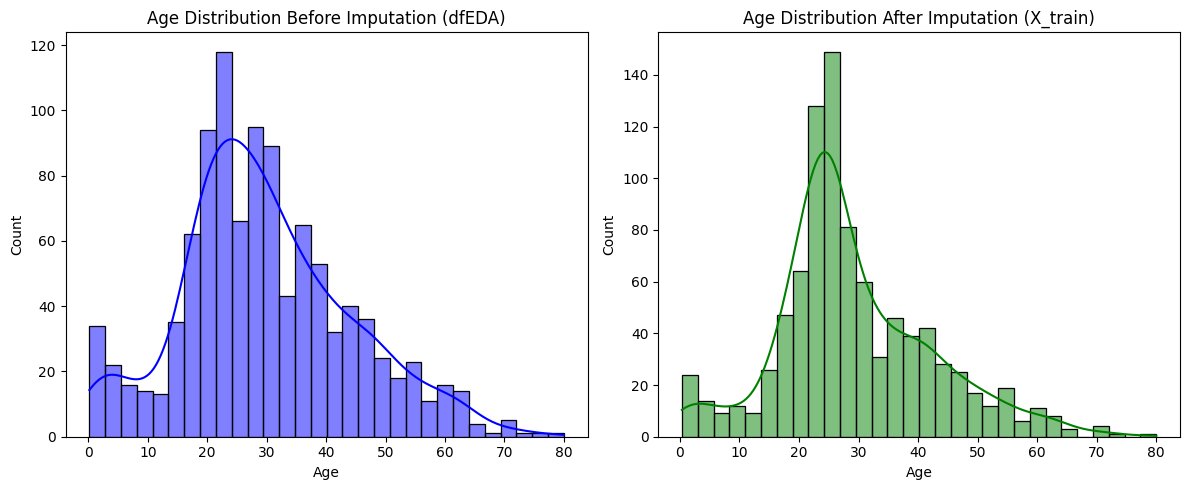

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# Before Imputation using dfEDA the original dataset
sns.histplot(dfEDA["age"].dropna(), bins=30, kde=True, ax=ax[0], color="blue")
ax[0].set_title("Age Distribution Before Imputation (dfEDA)")
ax[0].set_xlabel("Age")
# After Imputation using X_train tge modified dataset
sns.histplot(X_train["age"], bins=30, kde=True, ax=ax[1], color="green")
ax[1].set_title("Age Distribution After Imputation (X_train)")
ax[1].set_xlabel("Age")
plt.tight_layout()
plt.show()

Before impuation (blue) the distribution is right skewed 
After grouped median impuation (green) I managed to get much closer to the original distribution as opposed to simple median imputation. The shape remains right skewed closely mimicing the real demographic struct.

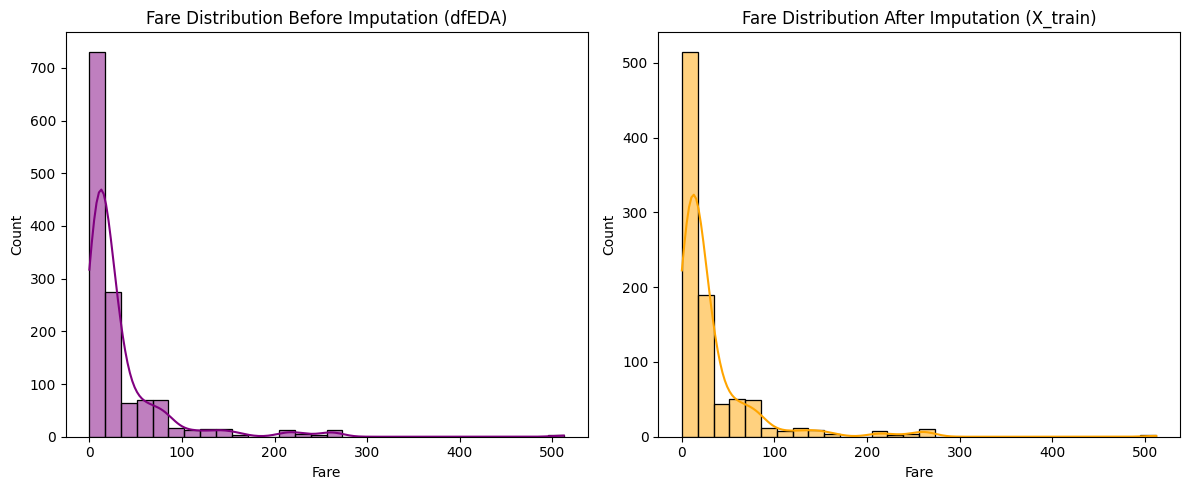

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# Before Imputation (dfEDA)
sns.histplot(dfEDA["fare"].dropna(), bins=30, kde=True, ax=ax[0], color="purple")
ax[0].set_title("Fare Distribution Before Imputation (dfEDA)")
ax[0].set_xlabel("Fare")
# After Imputation (X_train)
sns.histplot(X_train["fare"], bins=30, kde=True, ax=ax[1], color="orange")
ax[1].set_title("Fare Distribution After Imputation (X_train)")
ax[1].set_xlabel("Fare")
plt.tight_layout()
plt.show()

The distribution before and after imputation remains very similar, indicating that median imputation worked well.


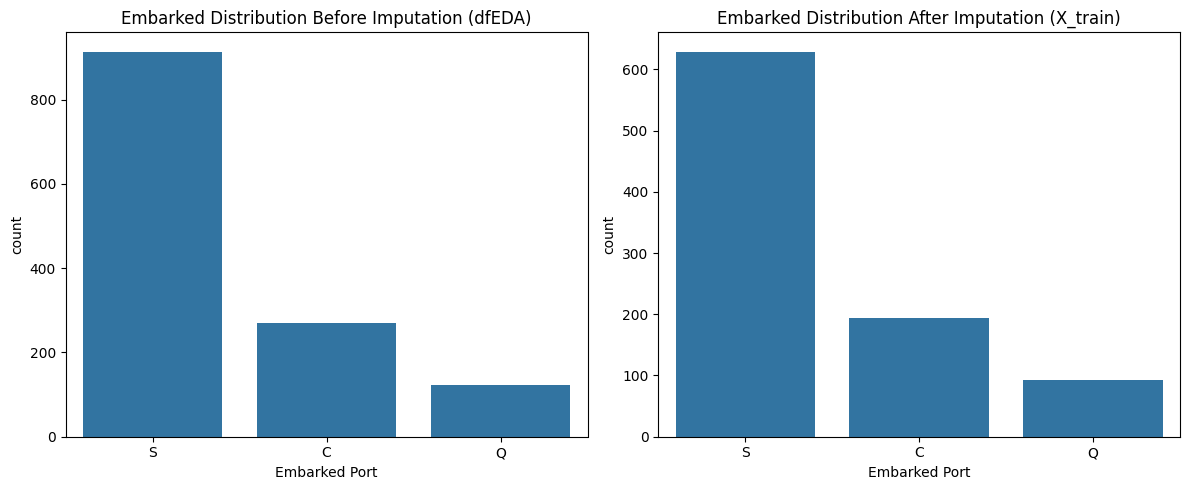

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# Before Imputation (dfEDA)
sns.countplot(x=dfEDA["embarked"].dropna(), order=dfEDA["embarked"].value_counts().index, ax=ax[0])
ax[0].set_title("Embarked Distribution Before Imputation (dfEDA)")
ax[0].set_xlabel("Embarked Port")
# After Imputation (X_train)
sns.countplot(x=X_train["embarked"], order=X_train["embarked"].value_counts().index, ax=ax[1])
ax[1].set_title("Embarked Distribution After Imputation (X_train)")
ax[1].set_xlabel("Embarked Port")
plt.tight_layout()
plt.show()

The mode imputation slightly increased the frequency of the most common embarkation port (S) but overall the distribution remains stable.


# Step 4: Feature Engineering & Encoding of Categorical Variables

This will be a large portion here....

1. Create a FamilySize Feature:
    - Passangers travelling in groups likley had higher survival rates compared to solo travels

2. Binning Age into ageGroup:
    - children had had priority implying age is non-linear in relation to survival 
    - Child 0-12, Teen 13-19, Adult 20-50, Senior 50+

3. Create Pclass_Sex_Interaction Feature
    - From EDA we saw women in 1st class had a high survial rate while men in 3rd class had the lowest survival rate
    - We can do this by combining pclass and sex


Encoding categorical variables

1. Binary Encoding for sex

2. OHE for Embarked and pclass and convert them into dummy variables

3. OHE for AgeGroup and Pclass_Sex_Interaction as they are categorical 

In [25]:
# Feature Engineering -> here I create the FamilSize feature
X_train["FamilySize"] = X_train["sibsp"] + X_train["parch"] + 1
X_val["FamilySize"] = X_val["sibsp"] + X_val["parch"] + 1
X_test["FamilySize"] = X_test["sibsp"] + X_test["parch"] + 1
# Age Binning as I described will categorise continous values into discrete bins
age_bins = [0, 12, 19, 50, 100]
age_labels = ["Child", "Teen", "Adult", "Senior"]
X_train["AgeGroup"] = pd.cut(X_train["age"], bins=age_bins, labels=age_labels)
X_val["AgeGroup"] = pd.cut(X_val["age"], bins=age_bins, labels=age_labels)
X_test["AgeGroup"] = pd.cut(X_test["age"], bins=age_bins, labels=age_labels)
# completing the Pclass-Sex Interaction Feature
X_train["Pclass_Sex"] = X_train["pclass"].astype(str) + "_" + X_train["sex"]
X_val["Pclass_Sex"] = X_val["pclass"].astype(str) + "_" + X_val["sex"]
X_test["Pclass_Sex"] = X_test["pclass"].astype(str) + "_" + X_test["sex"]
# Encoding sex to a binary encoding 
X_train["sex"] = X_train["sex"].map({"male": 0, "female": 1})
X_val["sex"] = X_val["sex"].map({"male": 0, "female": 1})
X_test["sex"] = X_test["sex"].map({"male": 0, "female": 1})
# OHE for Embarked, Pclass, AgeGroup, and Pclass_Sex Interaction
X_train = pd.get_dummies(X_train, columns=["embarked", "pclass", "AgeGroup", "Pclass_Sex"], drop_first=True)
X_val = pd.get_dummies(X_val, columns=["embarked", "pclass", "AgeGroup", "Pclass_Sex"], drop_first=True)
X_test = pd.get_dummies(X_test, columns=["embarked", "pclass", "AgeGroup", "Pclass_Sex"], drop_first=True)
# printing the first few rows to see how our dataset has been transformed 
print(X_train.head())

      sex   age  sibsp  parch     fare  FamilySize  embarked_Q  embarked_S  \
306     0  54.0      0      1  77.2875           2       False        True   
927     0  25.0      1      0  14.4542           2       False       False   
642     0  13.0      4      2  31.3875           7       False        True   
1294    0  28.5      0      0  16.1000           1       False        True   
1015    0  55.5      0      0   8.0500           1       False        True   

      pclass_2  pclass_3  AgeGroup_Teen  AgeGroup_Adult  AgeGroup_Senior  \
306      False     False          False           False             True   
927      False      True          False            True            False   
642      False      True           True           False            False   
1294     False      True          False            True            False   
1015     False      True          False           False             True   

      Pclass_Sex_1_male  Pclass_Sex_2_female  Pclass_Sex_2_male  \
306    

In [26]:
# Align columns between the training, validation, and test sets
X_train, X_val = X_train.align(X_val, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)
# Check the number of features again after aligning
print(f"Number of features in training set: {X_train.shape[1]}")
print(f"Number of features in validation set: {X_val.shape[1]}")
print(f"Number of features in test set: {X_test.shape[1]}")


Number of features in training set: 18
Number of features in validation set: 18
Number of features in test set: 18


Answering: Observe the transformation and discuss its impact on machine learning models.

I put a lot of work into feature engineering and OHE to make sure the dataset is actually useful. By dropping raw categorical variables and replacing them with binary indicators for embarked and pclass, the model should have an easier time picking up patterns. I extended this idea by creating interaction terms between pclass and sex, which should help capture more meaningful relationships. Binning age into categories should make survival trends more noticeable, especially since the relationship between age and survival isn’t purely linear. FamilySize gives a better way to analyze group survival dynamics instead of looking at sibsp and parch separately.

This setup should prevent the model from making bad assumptions about numerical values that aren’t actually sequential. I still need to check that I haven’t unnecessarily increased dimensionality with OHE, since too many features could lead to overfitting. If needed, I can drop less useful features after checking their importance and correlations. Overall, these transformations should create a cleaner dataset that generalizes better on test data without weird artifacts from the raw categorical variables.

In [27]:
X_train.head()

,sex,age,sibsp,parch,fare,FamilySize,embarked_Q,embarked_S,pclass_2,pclass_3,AgeGroup_Teen,AgeGroup_Adult,AgeGroup_Senior,Pclass_Sex_1_male,Pclass_Sex_2_female,Pclass_Sex_2_male,Pclass_Sex_3_female,Pclass_Sex_3_male
306,0,54.0,0,1,77.2875,2,False,True,False,False,False,False,True,True,False,False,False,False
927,0,25.0,1,0,14.4542,2,False,False,False,True,False,True,False,False,False,False,False,True
642,0,13.0,4,2,31.3875,7,False,True,False,True,True,False,False,False,False,False,False,True
1294,0,28.5,0,0,16.1000,1,False,True,False,True,False,True,False,False,False,False,False,True
1015,0,55.5,0,0,8.0500,1,False,True,False,True,False,False,True,False,False,False,False,True


In [28]:
# These are still in X_train and now redundant
drop_cols = ["sibsp", "parch", "age","sex"]  
# Drop them 
X_train.drop(columns=drop_cols, inplace=True)
X_val.drop(columns=drop_cols, inplace=True)
X_test.drop(columns=drop_cols, inplace=True)


In [29]:
X_train.head()

,fare,FamilySize,embarked_Q,embarked_S,pclass_2,pclass_3,AgeGroup_Teen,AgeGroup_Adult,AgeGroup_Senior,Pclass_Sex_1_male,Pclass_Sex_2_female,Pclass_Sex_2_male,Pclass_Sex_3_female,Pclass_Sex_3_male
306,77.2875,2,False,True,False,False,False,False,True,True,False,False,False,False
927,14.4542,2,False,False,False,True,False,True,False,False,False,False,False,True
642,31.3875,7,False,True,False,True,True,False,False,False,False,False,False,True
1294,16.1000,1,False,True,False,True,False,True,False,False,False,False,False,True
1015,8.0500,1,False,True,False,True,False,False,True,False,False,False,False,True


# Step 5: Feature Scaling

I chose the StandardScaler because it’s the best option for logistic regression, which works best with normally distributed features. The Z-score normalization helps center the features around 0 and standardize them with unit variance, making sure no feature dominates the others because of its scale. I only scaled fare and FamilySize because they are the continuous numerical features in the dataset. Scaling these ensures the model treats them equally, while categorical variables like sex or AgeGroup don’t need scaling since they don’t affect the model in the same way.

(https://medium.com/@draj0718/logistic-regression-with-standardscaler-from-the-scratch-ec01def674e8)

In [30]:
# numerical features to scale
numeric_features = ["fare", "FamilySize"]
# inititializing the StandardScaler
scaler = StandardScaler()
# Fit only on training data (wont make this mistake again....)
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
# Apply same transformation to validation and test sets
X_val[numeric_features] = scaler.transform(X_val[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])
# Confirm scaling worked
print(X_train.head())

          fare  FamilySize  embarked_Q  embarked_S  pclass_2  pclass_3  \
306   0.905927    0.083146       False        True     False     False   
927  -0.366777    0.083146       False       False     False      True   
642  -0.023788    3.310339       False        True     False      True   
1294 -0.333441   -0.562293       False        True     False      True   
1015 -0.496495   -0.562293       False        True     False      True   

      AgeGroup_Teen  AgeGroup_Adult  AgeGroup_Senior  Pclass_Sex_1_male  \
306           False           False             True               True   
927           False            True            False              False   
642            True           False            False              False   
1294          False            True            False              False   
1015          False           False             True              False   

      Pclass_Sex_2_female  Pclass_Sex_2_male  Pclass_Sex_3_female  \
306                 False          

Discuss the differences between standardization and normalization, along with their importance: Standardization (using StandardScaler) adjusts data so it has a mean of 0 and standard deviation of 1, which helps models like Logistic Regression perform better by treating all features equally. Normalization resizes data to fit within a specific range like 0 to 1 and is useful for models that rely on distances, like KNN. for Logistic Regression standardization is better because it helps the model treat all features fairly and improves its performance.















# Task 6: Addressing Class Imbalance

The titanic is an imbalanced dataset (38% survival rate) meaning the model might favour predicting non survivors.
I could randomly duplicate instances of the minority class but this could lead to overfiittng issues and also doesnt introduce variability in the model. Undersampling the majority class would lead to the loss of valuable information in the majority class. With less training data the model may fail to caputer patterns and variance of the smaller data set may make predictions worse. 

Here I read online that we could use class_weight = 'balanced' as it would automatically adjust weights of classes during training. I changed my mind after reading this very opinionated blog about it: (https://pastorjordi.github.io/blog/2022/balance_weights_logreg/)

Instead I will just fall back on SMOTE for these reasons: 
- it will create new realisitc samples y interpolating exisiting minority class samples i.e survivors
- We wont loose valualbe information in the majority class 
- SMOTE will capture patterns in the minority class (since survival is a complex decsion based on many factors) and it wont treat them as noise
- In essence I want to use SMOTE becuase it will create diverse synthetic examples instead of simple duplicates

I didnt choose ADASYN it focuses on the harder to learn minority class examples and I wont run the risk of introducitng more variation creating noise in the dataset. 

In [31]:
# Check on class distribution before applying SMOTE
train_class_dist_before = y_train.value_counts()
print("Class distribution before SMOTE:")
print(train_class_dist_before)


Class distribution before SMOTE:
survived
0    566
1    350
Name: count, dtype: int64


In [32]:

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


In [33]:
# class distribution after applying SMOTE
train_class_dist_after = y_train_smote.value_counts()
print("Class distribution after SMOTE:")
print(train_class_dist_after)


Class distribution after SMOTE:
survived
0    566
1    566
Name: count, dtype: int64


# Task 7: Feature Selection

In this step I want to reduce overfitting by eliminating some uncessary complexity I might have added. Linked to this remove irrelevant or redunadnt features. 

Plan for doing this:
1. Eliminate low-variance features (will review this if the model performs porly otherwise leave it for the purpose of time)
2. Remove highly correlated features -> can lead to multicollinearity

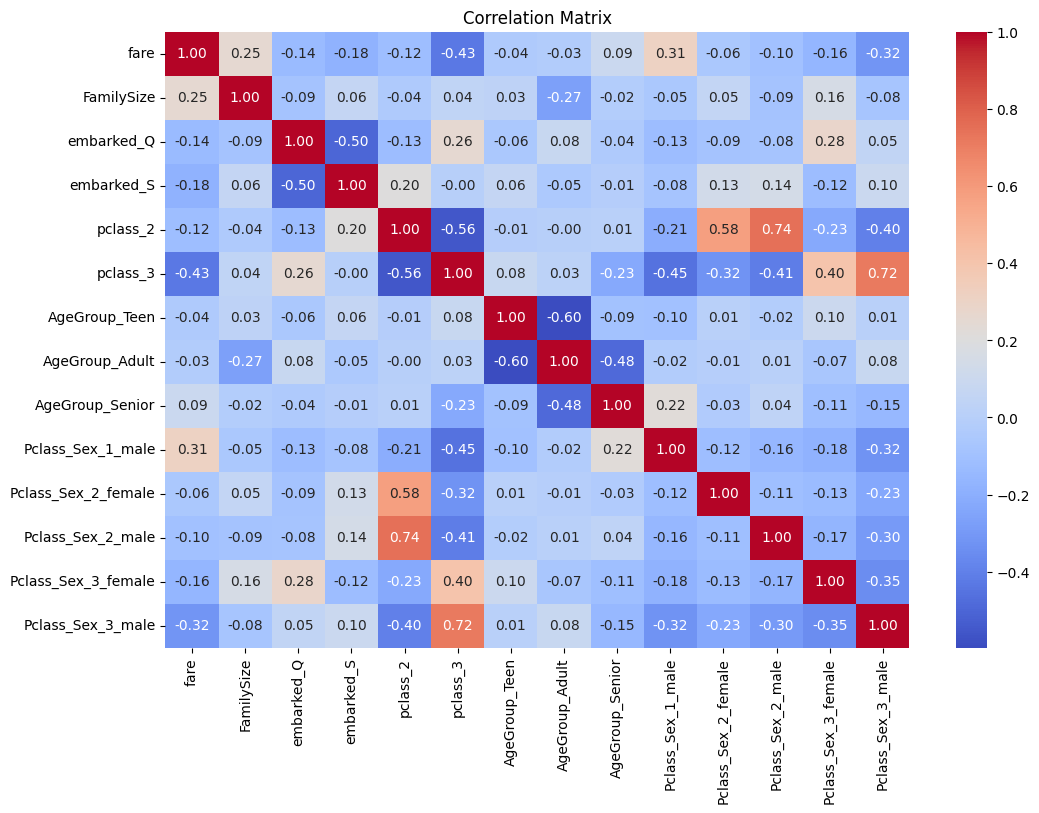

In [34]:
correlation_matrix = X_train.corr()
# Display the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


- Pclass_Sex_2_male and Pclass_Sex_2_female are closely tied to pclass_2.
- Pclass_Sex_3_male and Pclass_Sex_3_female are closely tied to pclass_3.

How I will address this: 
Pclass_sex...: capture both class and gender information which are important predictors of survival. They provide more specific details by combining both features, and since gender was a key determinant in the survival rate (women had a higher chance of survival in certain classes) it's crucial to retain these interaction terms. pclass feature alone doesnt provide as much specificity compared to the interaction terms. Since ive already captured class and gender in the interaction terms the standalone pclass_ features become redundant and do not add much extra value

In [42]:
# Drop the pclass features and keep Pclass_Sex_* interaction terms
columns_to_drop = ["pclass_2", "pclass_3"]
# Drop the columns from all datasets, including SMOTE-augmented training data
X_train.drop(columns=columns_to_drop, inplace=True, errors="ignore")
X_train_smote.drop(columns=columns_to_drop, inplace=True, errors="ignore")  # Fix for SMOTE issue
X_val.drop(columns=columns_to_drop, inplace=True, errors="ignore")
X_test.drop(columns=columns_to_drop, inplace=True, errors="ignore")
# Double check the number of features after dropping
print(f"Number of features after feature selection (Train): {X_train.shape[1]}")
print(f"Number of features after feature selection (Train SMOTE): {X_train_smote.shape[1]}")
print(f"Number of features after feature selection (Validation): {X_val.shape[1]}")
print(f"Number of features after feature selection (Test): {X_test.shape[1]}")
# Ensure all feature sets have the same columns
assert list(X_train_smote.columns) == list(X_val.columns) == list(X_test.columns), "Mismatch in feature columns!"


Number of features after feature selection (Train): 12
Number of features after feature selection (Train SMOTE): 12
Number of features after feature selection (Validation): 12
Number of features after feature selection (Test): 12


In [43]:
# Align the columns to ensure consistency between train, validation, and test sets
X_train, X_val = X_train.align(X_val, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)
# Now check the columns
print(f"Number of features in training set: {X_train.shape[1]}")
print(f"Number of features in validation set: {X_val.shape[1]}")
print(f"Number of features in test set: {X_test.shape[1]}")


Number of features in training set: 12
Number of features in validation set: 12
Number of features in test set: 12


I had to double check this with chatgpt just to make sure: pclass_1 is represented by the interaction terms like Pclass_Sex_1_male and Pclass_Sex_1_female, so there is no loss of information about the first class when you drop the simple pclass_1 column.

# Step 8: Train a Logistic Regression Model

In [45]:
# Here initialize the Logistic Regression model by creating an instance of it.
model = LogisticRegression(random_state=42)

# Train the model on the training data
model.fit(X_train_smote, y_train_smote)  
# Predict on the validation set
y_val_pred = model.predict(X_val)

# Evaluate the model on validation data
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred)}")
print("Classification Report on Validation Set:")
print(classification_report(y_val, y_val_pred))

# Predict on the test set (final evaluation)
y_test_pred = model.predict(X_test)

# Evaluate the model on the test data
# using precision, recall,f1-score and # of occurances in each class
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred)}")
print("Classification Report on Test Set:")
print(classification_report(y_test, y_test_pred))


Validation Accuracy: 0.8010204081632653
Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       121
           1       0.73      0.76      0.75        75

    accuracy                           0.80       196
   macro avg       0.79      0.79      0.79       196
weighted avg       0.80      0.80      0.80       196

Test Accuracy: 0.8020304568527918
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       122
           1       0.74      0.75      0.74        75

    accuracy                           0.80       197
   macro avg       0.79      0.79      0.79       197
weighted avg       0.80      0.80      0.80       197



The logistic regression model successfully trained and achieved an accuracy of ~80.1% on the validation set and ~80.2% on the test set, indicating strong generalization without significant overfitting.
The precsion-rcal demonstrates that the model pefroms across both classes with a 84%  precision and recall in class 0. While a slighly lower precision 74% and recal 75% on the Class 1. Implying that the model is somewhat better at predicting non-surviors thatn surviros. The imbalance shows room for improvment particularly in recall for survivors to reduce false negatives. Overall happy with how the remake of this assignment went!